<a href="https://colab.research.google.com/github/MianzhiHu/Propofol/blob/master/mixed_effect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c("lme4", "optimx", "lmerTest", "emmeans", "effects", "pbkrtest"))

In [ ]:
library(dplyr) 
library(ggplot2)
library(tidyverse)
library(lme4)
library(optimx)
library(emmeans)
library(lmerTest)
library(effects)

In [ ]:
# Summarize data files with a mean r squared below 0.9
bad <- read.csv("/hurst_averages.csv") %>%
  separate(key, into = c("subject","nan1", "condition", "sedation_level", "nan2"), convert = TRUE, sep = "_") %>%
  select("subject", "condition", "sedation_level", "hurst_average", "r_squared") %>%
  mutate(sedation_level = as.character(sedation_level)) %>%
  mutate(sedation_level = fct_recode(sedation_level,
                                "Awake" = "1",
                                "Mild" = "2",
                                "Deep" = "3",
                                "Recovery" = "4")) %>%
  filter(r_squared < 0.9)

bad
                                

In [ ]:
# Preprocess hurst averages
x <- read.csv("/content/hurst_averages.csv") %>%
  separate(key, into = c("subject","nan1", "condition", "sedation_level", "nan2"), convert = TRUE, sep = "_") %>%
  select("subject", "condition", "sedation_level", "hurst_average", "r_squared") %>%
  mutate(sedation_level = as.character(sedation_level)) %>%
  mutate(sedation_level = fct_recode(sedation_level,
                                "Awake" = "1",
                                "Mild" = "2",
                                "Deep" = "3",
                                "Recovery" = "4")) %>%
  filter(r_squared > 0.9)
x$subject <- factor(x$subject)
x$sedation_level <- factor(x$sedation_level, levels=c("Awake","Mild", "Deep", "Recovery")) 
x$condition <- factor(x$condition, levels=c("rest","movie")) 
 

contrasts(x$sedation_level) = contr.poly(4)
options(contrasts=c("contr.sum","contr.poly"))

# Normalize the data
x$hurst <- scale(x$hurst_average) 

x

In [ ]:
# Incoporate framewise displacement
y <- read.csv("/ss_out_review_compiled_ANAT.csv") %>%
  rename("subject" = "sub",
          "condition" = "task",
          "sedation_level" = "run") %>%
  mutate(sedation_level = as.character(sedation_level)) %>%
  mutate(sedation_level = fct_recode(sedation_level,
                                "Awake" = "1",
                                "Mild" = "2",
                                "Deep" = "3",
                                "Recovery" = "4")) %>%
  full_join(x, by = c("subject", "sedation_level", "condition"))

ggplot(data = y) +
  geom_line(aes(x = motion, y = r_squared)) +
  geom_smooth(aes(x = motion, y = r_squared))

y

In [ ]:
# In case
z <- y %>%
  filter(r_squared > 0.9)

z

In [ ]:
# Main effect of sedation level
mixed_effect_total = lmer(hurst ~ sedation_level + (1 | subject) + (1 | condition), data=x)
summary(mixed_effect_total)
anova(mixed_effect_total)
plot(allEffects(mixed_effect_total))
emmeans(mixed_effect_total, list(pairwise ~ sedation_level), adjust = "tukey")

In [ ]:
# Main effect of movie/rest condition
mixed_effect_condition = lmer(hurst ~ condition + (1 | subject) + (1 | sedation_level), data=x)
summary(mixed_effect_condition)
plot(allEffects(mixed_effect_condition))

In [ ]:
# Main effect of sedation level within the movie condition
movie <- x %>%
  filter(condition == "movie")

mixed_effect_movie = lmer(hurst ~ sedation_level + (1 | subject), data=movie)
summary(mixed_effect_movie)
anova(mixed_effect_movie)
plot(allEffects(mixed_effect_movie))
emmeans(mixed_effect_movie, list(pairwise ~ sedation_level), adjust = "tukey")

In [ ]:
# Main effect of sedation level within the rest condition
rest <- x %>%
  filter(condition == "rest")

mixed_effect_rest = lmer(hurst ~ sedation_level + (1 | subject), data=rest)
summary(mixed_effect_rest)
anova(mixed_effect_rest)
plot(allEffects(mixed_effect_rest))
emmeans(mixed_effect_rest, list(pairwise ~ sedation_level), adjust = "tukey")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level * condition + (1 | subject)
   Data: x

REML criterion at convergence: 285.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9290 -0.7005  0.0621  0.7656  2.0311 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.1077   0.3282  
 Residual             0.8210   0.9061  
Number of obs: 102, groups:  subject, 17

Fixed effects:
                            Estimate Std. Error       df t value Pr(>|t|)   
(Intercept)                 -0.03375    0.12262 17.13745  -0.275  0.78639   
sedation_level.L            -0.07405    0.17716 83.60120  -0.418  0.67705   
sedation_level.Q            -0.25568    0.18693 85.97597  -1.368  0.17495   
sedation_level.C             0.01244    0.19361 82.82897   0.064  0.94890   
condition1                   0.15067    0.09269 82.70788   1.625  0.10787   
sedation_level.L:condition1  0.05183    0.17606

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,1.774260,0.5914201,3,84.04945,0.7203698,0.54258342
condition,2.169199,2.1691985,1,82.70788,2.6421579,0.10786685
sedation_level:condition,9.414902,3.1383008,3,82.30226,3.8225576,0.01285705


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level, condition`
 sedation_level condition  emmean    SE   df lower.CL upper.CL
 Awake          rest       0.3235 0.241 89.0   -0.155  0.80197
 Mild           rest      -0.1991 0.249 89.8   -0.693  0.29478
 Deep           rest       0.1789 0.290 92.8   -0.396  0.75394
 Recovery       rest       0.1644 0.241 89.0   -0.314  0.64284
 Awake          movie     -0.5529 0.277 92.3   -1.104 -0.00226
 Mild           movie      0.4371 0.277 92.2   -0.114  0.98817
 Deep           movie     -0.0405 0.339 93.9   -0.713  0.63198
 Recovery       movie     -0.5814 0.277 92.3   -1.132 -0.03049

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level, condition`
 1                              estimate    SE   df t.ratio p.value
 Awake rest - Mild rest           0.5226 0.327 80.0   1.596  0.7512
 Awake rest - Deep rest           0.1447 0.360 82.7   0.402  0.9999
 Awake rest - Recovery rest       0.1591 0.321 79.3   0.495  0.

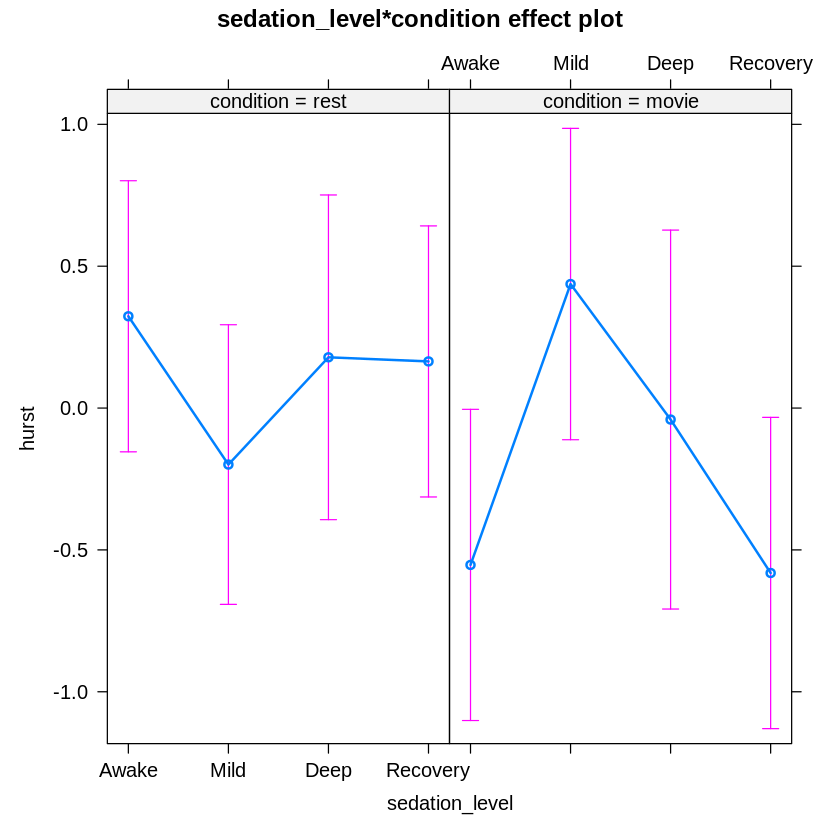

In [30]:
# Interaction effects
mixed_effect = lmer(hurst ~ sedation_level*condition + (1 | subject), data=x)
summary(mixed_effect)
anova(mixed_effect)
plot(allEffects(mixed_effect))
emmeans(mixed_effect, list(pairwise ~ sedation_level*condition), adjust = "tukey")

In [ ]:
## The following code is to analyze wavelet hurst
# Preprocess wavelet hurst averages
wavelet <- read.csv("/content/wavelet_df_mean.csv") %>%
  separate(X, into = c("subject","nan1", "condition", "sedation_level", "nan2"), convert = TRUE, sep = "_")  %>%
  select("subject", "condition", "sedation_level", "hurst_average") %>%
  mutate(sedation_level = as.character(sedation_level)) %>%
  mutate(sedation_level = fct_recode(sedation_level,
                                "Awake" = "1",
                                "Mild" = "2",
                                "Deep" = "3",
                                "Recovery" = "4"))
wavelet$subject <- factor(wavelet$subject)
wavelet$sedation_level <- factor(wavelet$sedation_level, levels=c("Awake","Mild", "Deep", "Recovery")) 
wavelet$condition <- factor(wavelet$condition, levels=c("rest","movie")) 
 

contrasts(wavelet$sedation_level) = contr.poly(4)
options(contrasts=c("contr.sum","contr.poly"))

# Normalize the data
wavelet$hurst <- scale(wavelet$hurst_average)

wavelet

In [ ]:
# Main effect of sedation level
wavelet_total = lmer(hurst ~ sedation_level + (1 | subject) + (1 | condition), data=wavelet)
summary(wavelet_total)
anova(wavelet_total)
plot(allEffects(wavelet_total))
emmeans(wavelet_total, list(pairwise ~ sedation_level), adjust = "tukey")

In [ ]:
# Main effect of movie/rest condition in wavelet
wavelet_condition = lmer(hurst ~ condition + (1 | subject) + (1 | sedation_level), data=wavelet)
summary(wavelet_condition)
plot(allEffects(wavelet_condition))

In [ ]:
# Main effect of sedation level within the movie condition in wavelet
movie_wavelet <- wavelet %>%
  filter(condition == "movie")

wavelet_movie = lmer(hurst ~ sedation_level + (1 | subject), data=movie_wavelet)
summary(wavelet_movie)
anova(wavelet_movie)
plot(allEffects(wavelet_movie))
emmeans(wavelet_movie, list(pairwise ~ sedation_level), adjust = "tukey")

In [ ]:
# Main effect of sedation level within the rest condition in wavelet
rest_wavelet <- wavelet %>%
  filter(condition == "rest")

wavelet_rest = lmer(hurst ~ sedation_level + (1 | subject), data=rest_wavelet)
summary(wavelet_rest)
anova(wavelet_rest)
plot(allEffects(wavelet_rest))
emmeans(wavelet_rest, list(pairwise ~ sedation_level), adjust = "tukey")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level * condition + (1 | subject)
   Data: wavelet

REML criterion at convergence: 270.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.16027 -0.51071  0.04279  0.59173  2.56465 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.006879 0.08294 
 Residual             0.911001 0.95446 
Number of obs: 96, groups:  subject, 17

Fixed effects:
                            Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)                  0.01376    0.10365 16.67100   0.133   0.8960  
sedation_level.L            -0.19315    0.19652 80.63312  -0.983   0.3286  
sedation_level.Q            -0.22084    0.20344 84.91851  -1.086   0.2808  
sedation_level.C             0.20138    0.20976 80.70893   0.960   0.3399  
condition1                  -0.12670    0.10163 80.92746  -1.247   0.2161  
sedation_level.L:condition1 -0.16732  

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,3.088863,1.029621,3,81.94549,1.130208,0.34177702
condition,1.415998,1.415998,1,80.92746,1.554333,0.21609340
sedation_level:condition,10.000089,3.333363,3,78.53337,3.659012,0.01589395


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level, condition`
 sedation_level condition  emmean    SE df lower.CL upper.CL
 Awake          rest       0.2839 0.240 88   -0.193    0.760
 Mild           rest      -0.2933 0.248 88   -0.786    0.199
 Deep           rest      -0.1366 0.291 88   -0.715    0.442
 Recovery       rest      -0.3057 0.232 88   -0.767    0.156
 Awake          movie     -0.3081 0.306 88   -0.916    0.299
 Mild           movie      0.8982 0.291 88    0.320    1.477
 Deep           movie      0.0284 0.367 88   -0.701    0.758
 Recovery       movie     -0.0567 0.323 88   -0.698    0.585

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level, condition`
 1                              estimate    SE   df t.ratio p.value
 Awake rest - Mild rest          0.57722 0.344 75.2   1.679  0.7004
 Awake rest - Deep rest          0.42051 0.376 78.9   1.118  0.9510
 Awake rest - Recovery rest      0.58959 0.333 73.6   1.772  0.6404
 Awake rest -

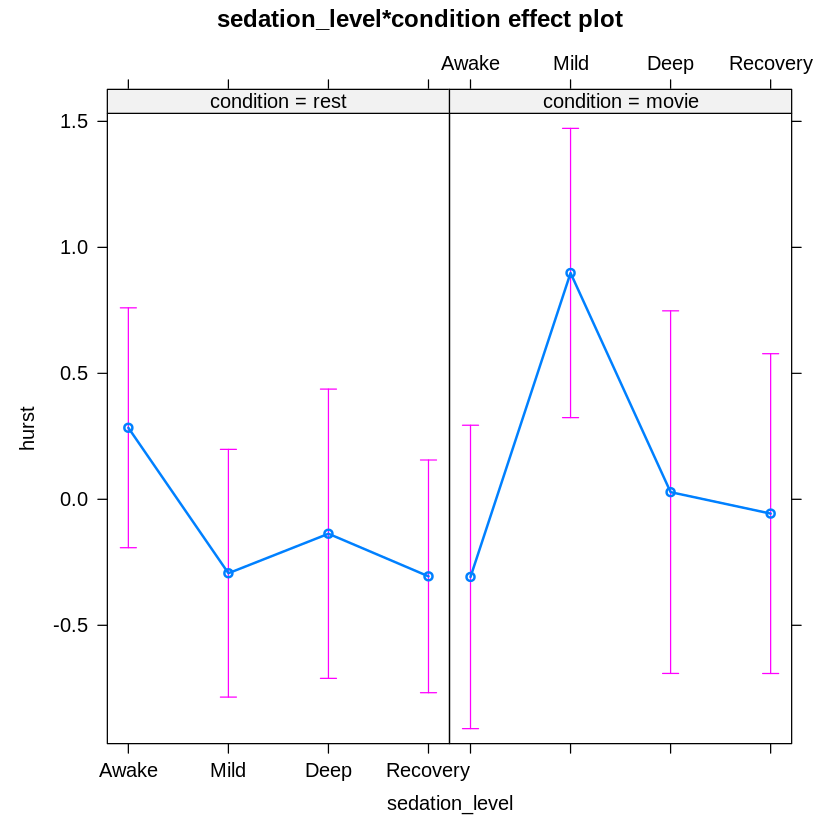

In [20]:
# Interaction effects
mixed_effect_wavelet = lmer(hurst ~ sedation_level*condition + (1 | subject), data=wavelet)
summary(mixed_effect_wavelet)
anova(mixed_effect_wavelet)
plot(allEffects(mixed_effect_wavelet))
emmeans(mixed_effect_wavelet, list(pairwise ~ sedation_level*condition), adjust = "tukey")

In [5]:
## The following code is to separate recovery early from recovery late (discarded)
# Separate recovery early from recovery late in the rest
rest_100 <- read.csv("/rest_100.csv") %>%
  separate(col = X, into = c("subject"), convert = TRUE, sep = "_") %>%
  mutate(recovery_early = rowMeans(across(X0:X9), na.rm = TRUE)) %>%
  mutate(recovery_late = rowMeans(across(X36:X45), na.rm = TRUE)) %>%
  mutate(condition = "rest") %>%
  select("subject", "recovery_early" ,"recovery_late", "condition") %>%
  pivot_longer(c("recovery_early", "recovery_late"), names_to = "sedation_level", values_to = "hurst_average") %>%
  mutate(hurst = scale(hurst_average)) %>%
  select("subject", "sedation_level", "hurst", "condition") %>%
  full_join(x, by = c("subject", "sedation_level", "hurst", "condition")) %>%
  filter(condition == "rest") %>%
  filter(sedation_level != "Recovery")

rest_100$subject <- factor(rest_100$subject)
rest_100$sedation_level <- factor(rest_100$sedation_level, levels=c("Awake","Mild", "Deep", "recovery_early", "recovery_late"))

contrasts(rest_100$sedation_level) = contr.poly(5)
options(contrasts=c("contr.sum","contr.poly"))

rest_100

Warning message in file(file, "rt"):
“cannot open file '/rest_100.csv': No such file or directory”


ERROR: ignored

In [ ]:
# Main effect of sedation level in the rest condition (recovery separated)
mixed_effect_rest_100 = lmer(hurst ~ sedation_level + (1 | subject), data=rest_100)
summary(mixed_effect_rest_100)
anova(mixed_effect_rest_100)
plot(allEffects(mixed_effect_rest_100))
emmeans(mixed_effect_rest_100, list(pairwise ~ sedation_level), adjust = "tukey")

In [ ]:
# Separate recovery early from recovery late in the movie condition
movie_100 <- read.csv("/movie_100.csv") %>%
  separate(col = X, into = c("subject"), convert = TRUE, sep = "_") %>%
  mutate(recovery_early = rowMeans(across(X0:X15), na.rm = TRUE)) %>%
  mutate(recovery_late = rowMeans(across(X49:X64), na.rm = TRUE)) %>%
  mutate(condition = "movie") %>%
  select("subject", "recovery_early" ,"recovery_late", "condition") %>%
  pivot_longer(c("recovery_early", "recovery_late"), names_to = "sedation_level", values_to = "hurst_average") %>%
  mutate(hurst = scale(hurst_average)) %>%
  select("subject", "sedation_level", "hurst", "condition") %>%
  full_join(x, by = c("subject", "sedation_level", "hurst", "condition")) %>%
  filter(condition == "movie") %>%
  filter(sedation_level != "Recovery")

movie_100$subject <- factor(movie_100$subject)
movie_100$sedation_level <- factor(movie_100$sedation_level, levels=c("Awake","Mild", "Deep", "recovery_early", "recovery_late"))

contrasts(movie_100$sedation_level) = contr.poly(5)
options(contrasts=c("contr.sum","contr.poly"))

movie_100

In [ ]:
# Main effect of sedation level in the movie condition (recovery separated)
mixed_effect_movie_100 = lmer(hurst ~ sedation_level + (1 | subject), data=movie_100)
summary(mixed_effect_movie_100)
anova(mixed_effect_movie_100)
plot(allEffects(mixed_effect_movie_100))
emmeans(mixed_effect_movie_100, list(pairwise ~ sedation_level), adjust = "tukey")

In [ ]:
# Separate recovery early from recovery late across movie/rest condition
total_100 <- rest_100 %>%
  full_join(movie_100)

total_100$subject <- factor(total_100$subject)
total_100$sedation_level <- factor(total_100$sedation_level, levels=c("Awake","Mild", "Deep", "recovery_early", "recovery_late"))

contrasts(total_100$sedation_level) = contr.poly(5)
options(contrasts=c("contr.sum","contr.poly"))

total_100

In [ ]:
# Interaction effects (recovery separated)
mixed_effect_total_100 = lmer(hurst ~ sedation_level*condition + (1 | subject), data=total_100)
summary(mixed_effect_total_100)
anova(mixed_effect_total_100)
plot(allEffects(mixed_effect_total_100))
emmeans(mixed_effect_total_100, list(pairwise ~ sedation_level*condition), adjust = "tukey")